# Conditonal Neural Processes For Colorization

Toy implementation of conditional neural processes in pytorch.
Based on [DeepMind's implementation](https://github.com/deepmind/neural-processes/blob/master/conditional_neural_process.ipynb).

## Conditional Neural Processes (CNP) for 1D regression.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import collections

import cv2
import glob
import math
import numpy as np
import os

from torch.utils.data import Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms


### Data Generator

In [2]:
class colordata(Dataset):
    def __init__(self, basedir, listdir, shape=(32,32), obs_num=100, split='train'):

        self.img_fns = []
        
        self.basedir = basedir
        with open('%s/list.%s.vae.txt' % (os.path.join(basedir, listdir), split), 'r') as ftr:
            for img_fn in ftr:
                self.img_fns.append(img_fn.strip('\n'))

        self.img_num = len(self.img_fns)
        self.shape = shape
        self.obs_num = obs_num # Number of observations
        
        # Create mapping from (x,y) coordinates to positional encodings
        self.x_enc, self.y_enc = self.create_position_encodings(size=shape[0])
        

    def __len__(self):
        return self.img_num
 
    def __getitem__(self, idx):
        color_ab = np.zeros((2, self.shape[0], self.shape[1]), dtype='f')
        recon_const = np.zeros((1, self.shape[0], self.shape[1]), dtype='f')

        img_large = cv2.imread(os.path.join(self.basedir,self.img_fns[idx]))
        if(self.shape is not None):
            img = cv2.resize(img_large, (self.shape[0], self.shape[1]))

        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert to lab color space

        img_lab = ((img_lab*2.)/255.)-1. #normalizing

        recon_const[0, :, :] = img_lab[..., 0] # gray image

        color_ab[0, :, :] = img_lab[..., 1].reshape(1, self.shape[0], self.shape[1])
        color_ab[1, :, :] = img_lab[..., 2].reshape(1, self.shape[0], self.shape[1])

        # Create list of all possible (x,y) coordinates
        indices = list(range(self.shape[0]*self.shape[1]))
        np.random.shuffle(indices)
        x_coords = np.hstack([np.array(list(range(self.shape[0]))).reshape(1,-1).T]*self.shape[0]).reshape(-1,)
        y_coords = np.vstack([np.array(list(range(self.shape[1]))).reshape(1,-1).T]*self.shape[1]).reshape(-1,)

        # Select obs_num number of coordinates for encoder
        x_coords_obs = x_coords[indices[:self.obs_num]]
        y_coords_obs = y_coords[indices[:self.obs_num]]
        # Create the positional encoding of the coordinates
        x_coords_obs_enc = self.x_enc[x_coords_obs]
        y_coords_obs_enc = self.y_enc[y_coords_obs]
        color_obs = color_ab[:,x_coords_obs, y_coords_obs]
        coords_obs = np.hstack((x_coords_obs_enc,y_coords_obs_enc,color_obs.T))

        # Select remaining number of coordinates for prediction decoder
        x_coords_pred = x_coords[indices[self.obs_num:]]
        y_coords_pred = y_coords[indices[self.obs_num:]]
        # Create the positional encoding of the coordinates
        x_coords_pred_enc = self.x_enc[x_coords_pred]
        y_coords_pred_enc = self.y_enc[y_coords_pred]
        coords_pred = np.hstack((x_coords_pred_enc,y_coords_pred_enc))
        pred_gt = color_ab[:,x_coords_pred, y_coords_pred].T

        return color_ab, recon_const, coords_obs, coords_pred, pred_gt, (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred)

    def create_position_encodings(self, size=32):
        H, W, C = size, size, 3

        L = 10 # parameter for size of encoding

        x_linspace = (np.linspace(0, W-1, W)/W)*2 -1 
        y_linspace = (np.linspace(0, H-1, H)/H)*2 -1

        x_el = []
        y_el = []

        x_el_hf = []
        y_el_hf = []

        # cache the values so you don't have to do function calls at every pixel
        for el in range(0, L):
            val = 2 ** el 
            x = np.sin(val * np.pi * x_linspace)
            x_el.append(x)

            x = np.cos(val * np.pi * x_linspace)
            x_el_hf.append(x)

            y = np.sin(val * np.pi * y_linspace)
            y_el.append(y)

            y = np.cos(val * np.pi * y_linspace)
            y_el_hf.append(y)

        x_el = np.array(x_el).T
        x_el_hf = np.array(x_el_hf).T
        y_el = np.array(y_el).T
        y_el_hf = np.array(y_el_hf).T

        return np.hstack((x_el, x_el_hf)), np.hstack((y_el, y_el_hf))


In [3]:
out_dir = 'output/lfw/'
basedir = 'pytorch_divcolor'
listdir = 'data/imglist/lfw/'

data_train = colordata(\
    shape = (32,32), \
    basedir=basedir,\
    listdir=listdir,\
    obs_num = 100,\
    split='train')

train_loader = DataLoader(dataset=data_train, num_workers=1,
                         batch_size=32, shuffle=True, drop_last=True)

data_test = colordata(\
    shape = (32,32), \
    basedir=basedir,\
    listdir=listdir,\
    obs_num = 100,\
    split='test')

test_loader = DataLoader(dataset=data_test, num_workers=1,
                         batch_size=32, shuffle=True, drop_last=True)


In [4]:
for i, (color_c, gray_c, obs, pred, pred_gt, (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
    print("Color channels (AB) image:")
    print("    ", color_c.shape)
    print("Gray channel (L) image:")
    print("    ", gray_c.shape)
    print("Number of observations coordinates with position encoding (40-dim) and color label (2-dim):")
    print("    ", obs.shape)
    print("Number of predictions coordinates with position encoding (40-dim):")
    print("    ", pred.shape)
    print("Number of predictions coordinates with gt color label(2-dim):")
    print("    ", pred_gt.shape)
    print("(x,y) coordinates of observations: ")
    print("    ", (x_coords_obs.shape, y_coords_obs.shape))
    print("(x,y) coordinates of predictions: ")
    print("    ", (x_coords_pred.shape, y_coords_pred.shape))
    break

Color channels (AB) image:
     torch.Size([32, 2, 32, 32])
Gray channel (L) image:
     torch.Size([32, 1, 32, 32])
Number of observations coordinates with position encoding (40-dim) and color label (2-dim):
     torch.Size([32, 100, 42])
Number of predictions coordinates with position encoding (40-dim):
     torch.Size([32, 924, 40])
Number of predictions coordinates with gt color label(2-dim):
     torch.Size([32, 924, 2])
(x,y) coordinates of observations: 
     (torch.Size([32, 100]), torch.Size([32, 100]))
(x,y) coordinates of predictions: 
     (torch.Size([32, 924]), torch.Size([32, 924]))


### Encoder

In [5]:
class DeterministicEncoder(nn.Module):
    def __init__(self, output_sizes):
        '''
        CNP encoder

        @param output_sizes: An iterable containing the output sizes of the encoding MLP.
        '''
        super(DeterministicEncoder, self).__init__()
        encoder = [nn.Linear(42, output_sizes[0]), nn.ReLU(inplace=True)]
        for i in range(1,len(output_sizes)):
            encoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                encoder += [nn.ReLU(inplace=True)]

        self.encoder = nn.Sequential(*encoder)


    def forward(self, context):
        '''
        Encodes the inputs into one representation.

        @param context_x: Tensor of size bs x observations x m_ch. For this 1D regression
            task this corresponds to the x-values.
        @param context_y: Tensor of size bs x observations x d_ch. For this 1D regression
            task this corresponds to the y-values.
        @param num_context_points: A tensor containing a single scalar that indicates the
            number of context_points provided in this iteration.
        @return representation: The encoded representation averaged over all context 
            points.
        '''
        encoder_input = context
        batch_size, num_context_points, _ = encoder_input.shape
        encoder_input = encoder_input.view(batch_size * num_context_points, -1)
        representation = self.encoder(encoder_input).view(batch_size, num_context_points, -1)
        return torch.mean(representation, dim=1)

In [8]:
# Testing encoder

encoder_output_sizes = [128, 256, 512, 512]
encoder = DeterministicEncoder(encoder_output_sizes)

for i, (color_c, gray_c, obs, pred, pred_gt, (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
    print(obs.shape)
    print(encoder(obs.float()).shape)
    break

torch.Size([32, 100, 42])
torch.Size([32, 512])


### Decoder

In [9]:
class DeterministicDecoder(nn.Module):
    def __init__(self, output_sizes):
        '''
        CNP decoder

        @param output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `nn.Linear`.
        '''
        super(DeterministicDecoder, self).__init__()
        decoder = [nn.Linear(512+40, output_sizes[0]), nn.ReLU(inplace=True)]
        for i in range(1, len(output_sizes)):
            decoder += [nn.Linear(output_sizes[i - 1], output_sizes[i])]
            if i != len(output_sizes) - 1:
                decoder += [nn.ReLU(inplace=True)]

        self.decoder = nn.Sequential(*decoder)


    def forward(self, decoder_input):
        '''
        Decodes the individual targets.

        @param representation: The encoded representation of the context
        @param target_x: The x locations for the target query
        @param num_total_points: The number of target points.
        @return dist: A multivariate Gaussian over the target points.
        @return mu: The mean of the multivariate Gaussian.
        @return sigma: The standard deviation of the multivariate Gaussian.
        '''
        batch_size, num_total_points, _ = decoder_input.shape
        decoder_input = decoder_input.view(batch_size * num_total_points, -1)

        output = self.decoder(decoder_input).view(batch_size, num_total_points, -1)

        # get the mean and variance
        mu_a, log_sigma_a, mu_b, log_sigma_b = torch.chunk(output, 4, dim=-1)

        # bound the variance
        sigma_a = 0.1 + 0.9 * F.softplus(log_sigma_a)
        sigma_b = 0.1 + 0.9 * F.softplus(log_sigma_b)

        # get the distribution
        dist_a = torch.distributions.multivariate_normal.MultivariateNormal(mu_a, covariance_matrix=torch.diag_embed(sigma_a))
        dist_b = torch.distributions.multivariate_normal.MultivariateNormal(mu_b, covariance_matrix=torch.diag_embed(sigma_b))

        return dist_a,  mu_a,  log_sigma_a, dist_b,mu_b,log_sigma_b

# Colorization Code

In [33]:
def decodeimg(img_enc):
    img_dec = (((img_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return cv2.resize(np.uint8(img_dec), (32,32))

def decodepixels(pixel_enc):
    img_dec = (((pixel_enc+1.)*1.)/2.)*255.
    img_dec[img_dec < 0.] = 0.
    img_dec[img_dec > 255.] = 255.
    return np.uint8(img_dec)

def visualize(gray_c, color_c, x_coords_pred, y_coords_pred, mu_a, mu_b, image = 0):
    image = image # image index to visualize from mini-batch

    img_lab = np.zeros((32,32,3), dtype='uint8') 
    img_lab[:,:,0] = decodeimg(gray_c[image].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,1] = decodeimg(color_c[image][0].cpu().numpy().reshape((32, 32)))
    img_lab[:,:,2] = decodeimg(color_c[image][1].cpu().numpy().reshape((32, 32)))

    gt = img_lab.copy()
    obs = img_lab

    img_lab[x_coords_pred[image],y_coords_pred[image],1:2] = decodepixels(mu_a[image].detach().cpu().numpy())
    img_lab[x_coords_pred[image],y_coords_pred[image],2:3] = decodepixels(mu_b[image].detach().cpu().numpy())

    orig_img = cv2.cvtColor(gt, cv2.COLOR_LAB2RGB)
    output_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    obs_img = cv2.cvtColor(obs, cv2.COLOR_LAB2RGB)

    obs_img[x_coords_pred[image], y_coords_pred[image]]=0

    plt.subplot(131)
    plt.axis('off'), plt.title("Observation Image")
    plt.imshow(obs_img)
    plt.subplot(132)
    plt.axis('off'), plt.title("Output")
    plt.imshow(output_img)
    plt.subplot(133)
    plt.axis('off'), plt.title("Original GT Image")
    plt.imshow(orig_img)
    plt.show()

# Overfitting to one example

Epoch  0


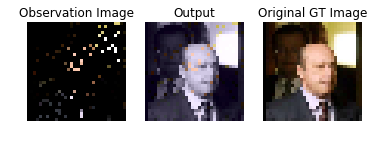

Loss:  1.5646579265594482
Loss a:  -0.7812934517860413
Loss b:  -0.783364474773407
===
Epoch  20


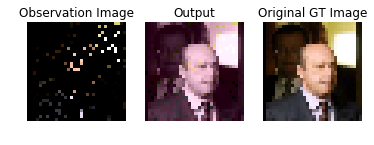

Loss:  -0.012741115831193469
Loss a:  0.006592723585310436
Loss b:  0.0061483922458830335
===
Epoch  40


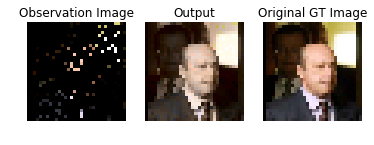

Loss:  -0.010035724174685595
Loss a:  0.005340939614830948
Loss b:  0.004694784196411691
===
Epoch  60


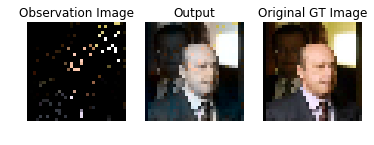

Loss:  -0.006413944431992828
Loss a:  0.0035468120066846002
Loss b:  0.0028671324253082275
===
Epoch  80


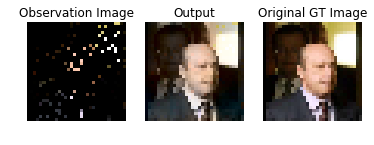

Loss:  -0.005245294099972572
Loss a:  0.0027585421447400694
Loss b:  0.0024867519552325026
===
Epoch  100


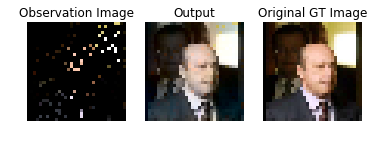

Loss:  -0.004079471720327245
Loss a:  0.0021814950326881784
Loss b:  0.0018979766876390666
===
Epoch  120


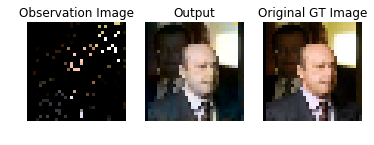

Loss:  -0.003439461396745414
Loss a:  0.001827195902501256
Loss b:  0.0016122654942441578
===
Epoch  140


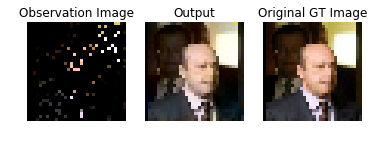

Loss:  -0.0030671184790049886
Loss a:  0.0016048394196422388
Loss b:  0.0014622790593627497
===


KeyboardInterrupt: 

In [37]:
encoder_output_sizes = [128, 256, 512, 512]
decoder_output_sizes = [512, 512, 256, 128, 4]
encoder = DeterministicEncoder(encoder_output_sizes).to(0)
decoder = DeterministicDecoder(decoder_output_sizes).to(0)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i, (color_c, gray_c, obs, preds, preds_gt, (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
    break

# Choose one example to overfit on
color_c, gray_c = color_c[0:1], gray_c[0:1]
obs, preds, preds_gt = obs[0:1], pred[0:1], preds_gt[0:1]
x_coords_obs, y_coords_obs = x_coords_obs[0:1], y_coords_obs[0:1]
x_coords_pred, y_coords_pred = x_coords_pred[0:1], y_coords_pred[0:1]
    
epochs = 1000 

for epoch in range(epochs):
    _loss, _loss_a, _loss_b = 0., 0., 0.
    optimizer.zero_grad()
    obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
    
    representation = encoder(obs.float())
    representation_expand = representation.unsqueeze(1).expand(-1,preds.shape[1],512)
    # Concatenate prediction coordinates with decoder output
    decoder_input = torch.cat((preds.float(), representation_expand),2) # bs x _ x (512+40)
    dist_a, mu_a, sigma_a, dist_b, mu_b, sigma_b = decoder(decoder_input)
    log_prob_a = dist_a.log_prob(preds_gt[:,:,0:1])
    log_prob_b = dist_b.log_prob(preds_gt[:,:,1:2])

    loss = -log_prob_a.mean() - log_prob_b.mean()
    loss.backward()
    optimizer.step()
    _loss += loss.item()
    _loss_a += log_prob_a.mean().item()
    _loss_b += log_prob_b.mean().item()
    
    if epoch % 20 == 0:
        print("Epoch ", epoch)
        visualize(gray_c, color_c, x_coords_pred, y_coords_pred, mu_a, mu_b)

        print("Loss: ", _loss/(epoch+1))
        print("Loss a: ", _loss_a/(epoch+1))
        print("Loss b: ", _loss_b/(epoch+1))
        print("===")

# Training Colorization Model

Loss:  1.5535194873809814
Loss a:  -0.7836953401565552
Loss b:  -0.7698241472244263


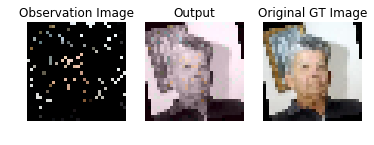

Loss:  1.5532019138336182
Loss a:  -0.7833862006664276
Loss b:  -0.7698157429695129


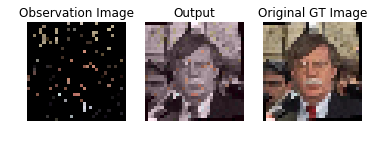

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [31]:
encoder_output_sizes = [128, 256, 512, 512]
decoder_output_sizes = [512, 512, 256, 128, 4]

encoder = DeterministicEncoder(encoder_output_sizes).to(0)
decoder = DeterministicDecoder(decoder_output_sizes).to(0)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

epochs = 10
visualize = 5

for epoch in range(epochs):
    _loss, _loss_a, _loss_b = 0., 0., 0.
    for i, (color_c, gray_c, obs, preds, preds_gt, (x_coords_obs, y_coords_obs), (x_coords_pred, y_coords_pred)) in enumerate(train_loader):
        optimizer.zero_grad()
        obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
        
        representation = encoder(obs.float())
        representation_expand = representation.unsqueeze(1).expand(-1,preds.shape[1],512)
        # Concatenate prediction coordinates with decoder output
        decoder_input = torch.cat((preds.float(), representation_expand),2) # bs x _ x (512+40)
        dist_a, mu_a, sigma_a, dist_b, mu_b, sigma_b = decoder(decoder_input)
        log_prob_a = dist_a.log_prob(preds_gt[:,:,0:1])
        log_prob_b = dist_b.log_prob(preds_gt[:,:,1:2])

        loss = -log_prob_a.mean() - log_prob_b.mean()
        loss.backward()
        optimizer.step()
        _loss += loss.item()
        _loss_a += log_prob_a.mean().item()
        _loss_b += log_prob_b.mean().item()
        if i % visualize == 0:
            print("Loss: ", _loss/(i+1))
            print("Loss a: ", _loss_a/(i+1))
            print("Loss b: ", _loss_b/(i+1))
            
        visualize(gray_c, color_c, x_coords_pred, y_coords_pred, mu_a, mu_b)
        
    print("Loss: ", _loss/(i+1))
    print("Loss a: ", _loss_a/(i+1))
    print("Loss b: ", _loss_b/(i+1))

In [216]:
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

# Test Visualizations

In [27]:
encoder_output_sizes = [128, 256, 512, 512]
decoder_output_sizes = [512, 512, 256, 128, 4]
encoder = DeterministicEncoder(encoder_output_sizes).to(0)
decoder = DeterministicDecoder(decoder_output_sizes).to(0)

encoder.load_state_dict(torch.load('encoder.pth'))
decoder.load_state_dict(torch.load('decoder.pth'))

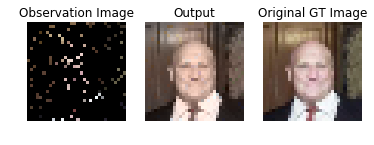

In [28]:
for i, (color_c, gray_c, obs, preds, preds_gt, 
        (x_coords_obs, y_coords_obs), 
        (x_coords_pred, y_coords_pred)) in enumerate(test_loader):
    break

obs, preds, preds_gt = obs.to(0), preds.to(0), preds_gt.to(0)
representation = encoder(obs.float())
representation_expand = representation.unsqueeze(1).expand(-1,preds.shape[1],512)
decoder_input = torch.cat((preds.float(), representation_expand),2) # bs x _ x (512+40)
dist_a, mu_a, sigma_a, dist_b, mu_b, sigma_b = decoder(decoder_input)

visualize(gray_c, color_c, x_coords_pred, y_coords_pred, mu_a, mu_b)